## qBraid Runtime: Bloqade batch submission to QuEra Aquila

In [ ]:
%%capture

%pip install 'qbraid[bloqade,visualization]>=0.8.8'

In [1]:
import numpy as np
from bloqade import var
from bloqade.atom_arrangement import Square

from qbraid import ConversionGraph, ExperimentType
from qbraid.runtime import QbraidProvider
from qbraid.visualization import plot_histogram

Create adiabatic program batch using Bloqade

In [2]:
adiabatic_durations = [0.4, 3.2, 0.4]

max_detuning = var("max_detuning")
adiabatic_program = (
    Square(3, lattice_spacing="lattice_spacing")
    .rydberg.rabi.amplitude.uniform.piecewise_linear(
        durations=adiabatic_durations, values=[0.0, "max_rabi", "max_rabi", 0.0]
    )
    .detuning.uniform.piecewise_linear(
        durations=adiabatic_durations,
        values=[
            -max_detuning,  # scalar variables support direct arithmetic operations
            -max_detuning,
            max_detuning,
            max_detuning,
        ],
    )
    .assign(max_rabi=15.8, max_detuning=16.33)
    .batch_assign(lattice_spacing=np.arange(4.0, 7.0, 1.0))
)

Target QuEra Aquila device using QbraidProvider

bloqade.builder.assign.BatchAssign

In [3]:
provider = QbraidProvider()

In [4]:
device = provider.get_device("quera_aquila")

print(device.status())
print(device.profile.experiment_type)
print(device.profile.program_spec)

DeviceStatus.UNAVAILABLE
ExperimentType.AHS
ProgramSpec(AnalogHamiltonianSimulation, braket_ahs)


In [5]:
from qbraid import QPROGRAM_REGISTRY

QPROGRAM_REGISTRY

{'braket': braket.circuits.circuit.Circuit,
 'braket_ahs': braket.ahs.analog_hamiltonian_simulation.AnalogHamiltonianSimulation,
 'openqasm3': openqasm3.ast.Program,
 'qasm2': str,
 'qasm3': str,
 'ionq': ~IonQDict,
 'qubo': ~QuboCoefficientsDict,
 'bloqade': bloqade.builder.assign.BatchAssign}

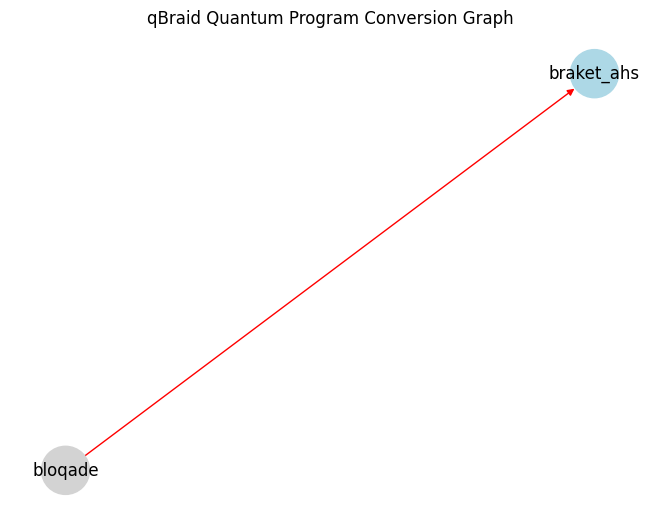

In [6]:
graph = ConversionGraph()

graph.plot(experiment_type=ExperimentType.AHS)

Submit quantum task(s)

/home/jovyan/.qbraid/environments/qbraid_zzef8a/pyenv/lib/python3.11/site-packages/qbraid/visualization/plot_conversions.py:132: UserWarning: Detected multiple edge colors, which may not display correctly due to a known bug in rustworkx versions 0.15.0 and 0.15.1 (see: https://github.com/Qiskit/rustworkx/issues/1308). To avoid this issue, please upgrade to rustworkx>0.15.1.
  warnings.warn(


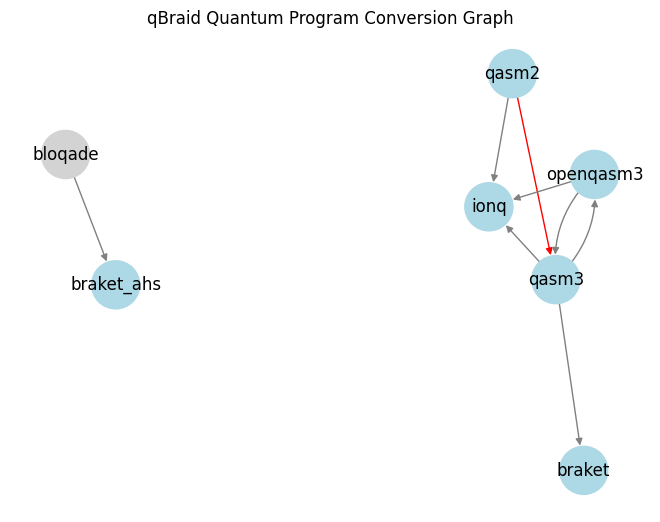

In [8]:
device.scheme.conversion_graph.plot()

In [ ]:
device.set_options(validate=0)

In [12]:
from qbraid.programs import ProgramSpec

In [13]:
braket_batch = device.transpile(adiabatic_program, ProgramSpec(type(adiabatic_program), alias="bloqade"))

/home/jovyan/.qbraid/environments/qbraid_zzef8a/pyenv/lib/python3.11/site-packages/bloqade/submission/braket.py:48: UserWarning: Could not retrieve device capabilities from braket API. Using local capabilities file for Aquila.
  warnings.warn(


In [ ]:
job_batch = device.run(adiabatic_program, shots=10, tags={"batch": "adiabatic-test-1"})

In [ ]:
print(f"{'Job Id':<60} {'Status':<15} {'Queue Position':<5}")
print("-" * 50)
for job in job_batch:
    print(f"{job.id:<60} {job.status():<15} {job.queue_position():<5}")

In [ ]:
results = [job.result() for job in job_batch]

shot_results_batch = [result.data.measurements for result in results]

counts_batch = [result.data.get_counts() for result in results]

In [ ]:
plot_histogram(counts_batch)